

Algorithm Summary:
    - We start with input sequences from a domain (words)
    and correspding target sequences from another domain(stemmed words)
    - An encoder LSTM maps a variable-length input sequence to a fixed-length vector
    - and a decoder LSTM maps the vector representation back to a variable-length target sequence
    - the decoder is being trained to generate targets[t+1...]
    given targets[...t], conditioned on the input sequence.
    
    

In [1]:
'''Sequence to sequence example in Ker
- Sequence to Sequence Learning with Neural Networks
    https://arxiv.org/abs/1409.3215
- Learning Phrase Representations using
    RNN Encoder-Decoder for Statistical Machine Translation
    https://arxiv.org/abs/1406.1078
'''
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np
from random import shuffle

Using TensorFlow backend.


Parameters and paths

In [9]:
batch_size = 64  # Batch size for training.
epochs = 30  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples =78200  #number of samples to train on, total 220975
model_name = 'old_s2s.h5' #model name for saving
data_path = 'resources/StemDictionaryModified(copy).txt' # train data path
test_data_path = 'resources/test.txt' #test data path

Vectorize the data


In [10]:
input_texts = []
target_texts = []
test_texts = []
input_characters = set()
target_characters = set()
test_characters = set()
lines = open(data_path).read()
lines = lines.split('\n')
shuffle(lines)
for line in lines[: min(num_samples, len(lines) - 1)]:
    line = line.rstrip(' ')
    if ' ' not in line: #if can't split
        continue
    if (len(line.split(' ')) != 2):
        continue
    
    input_text, target_text = line.split(' ')
    input_text = input_text +'\n'

    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'

    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        
        if char not in target_characters:
            target_characters.add(char)
            
#for test examples
with open(test_data_path, "r") as ins:
    for line in ins:
        test_text = line
        test_texts.append(test_text)
        for char in test_text:
            test_characters.add(char)

Mapping the characters to int and reverse int to characters


In [11]:
input_token_index = {}
k = 0

for j in range(2432,2560):
    input_token_index[chr(j)] = k
    k +=1

input_token_index['\t'] = k
k +=1
input_token_index['\n'] = k
k +=1
input_token_index[' '] = k
k +=1
input_token_index['\u200c'] = k
k +=1

input_token_index['\u200d'] = k
k +=1
input_token_index['\u200f'] = k
k +=1
input_token_index['¬'] = k
k +=1
input_token_index['\x9d'] = k
k +=1
input_token_index['\ufeff'] = k
k +=1
input_token_index['–'] = k
k +=1

# Reverse-lookup token index to decode sequences back to
# something readable.    
print(input_token_index)
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in input_token_index.items())

{'ঀ': 0, 'ঁ': 1, 'ং': 2, 'ঃ': 3, '\u0984': 4, 'অ': 5, 'আ': 6, 'ই': 7, 'ঈ': 8, 'উ': 9, 'ঊ': 10, 'ঋ': 11, 'ঌ': 12, '\u098d': 13, '\u098e': 14, 'এ': 15, 'ঐ': 16, '\u0991': 17, '\u0992': 18, 'ও': 19, 'ঔ': 20, 'ক': 21, 'খ': 22, 'গ': 23, 'ঘ': 24, 'ঙ': 25, 'চ': 26, 'ছ': 27, 'জ': 28, 'ঝ': 29, 'ঞ': 30, 'ট': 31, 'ঠ': 32, 'ড': 33, 'ঢ': 34, 'ণ': 35, 'ত': 36, 'থ': 37, 'দ': 38, 'ধ': 39, 'ন': 40, '\u09a9': 41, 'প': 42, 'ফ': 43, 'ব': 44, 'ভ': 45, 'ম': 46, 'য': 47, 'র': 48, '\u09b1': 49, 'ল': 50, '\u09b3': 51, '\u09b4': 52, '\u09b5': 53, 'শ': 54, 'ষ': 55, 'স': 56, 'হ': 57, '\u09ba': 58, '\u09bb': 59, '়': 60, 'ঽ': 61, 'া': 62, 'ি': 63, 'ী': 64, 'ু': 65, 'ূ': 66, 'ৃ': 67, 'ৄ': 68, '\u09c5': 69, '\u09c6': 70, 'ে': 71, 'ৈ': 72, '\u09c9': 73, '\u09ca': 74, 'ো': 75, 'ৌ': 76, '্': 77, 'ৎ': 78, '\u09cf': 79, '\u09d0': 80, '\u09d1': 81, '\u09d2': 82, '\u09d3': 83, '\u09d4': 84, '\u09d5': 85, '\u09d6': 86, 'ৗ': 87, '\u09d8': 88, '\u09d9': 89, '\u09da': 90, '\u09db': 91, 'ড়': 92, 'ঢ়': 93, '\u09de': 94, 'য়': 95, 

In [12]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
test_characters = sorted(list(test_characters))
num_encoder_tokens = len(input_token_index)
num_decoder_tokens = len(input_token_index)
num_encoder_tokens_test = len(input_token_index)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])
max_encoder_seq_length_test = max([len(txt)] for txt in test_texts)
max_decoder_seq_length_test = max([len(txt)] for txt in test_texts)
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)
print('Number of unique input token in test. ', num_encoder_tokens_test)

target_token_index = input_token_index


Number of samples: 78196
Number of unique input tokens: 138
Number of unique output tokens: 138
Max sequence length for inputs: 26
Max sequence length for outputs: 25
Number of unique input token in test.  138


Creacting numpy array for input , target and text sequences

In [13]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_encoder_tokens),
    dtype='float32')
encoder_input_data_test = np.zeros(
    (len(test_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')

Prepare numpy array by the dataset 

In [14]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    #print(input_text)

    for t, char in enumerate(input_text):
        # print(input_token_index[char])
        
        encoder_input_data[i, t, input_token_index[char]] = 1
    for t, char in enumerate(target_text):
        
        # decoder_target_data is ahead of decoder_input_data by one timestep
        
        decoder_input_data[i, t, target_token_index[char]] = 1
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]]  =1

for i in range(len(test_texts)):
    test_text = test_texts[i]

    for t, char in enumerate(test_text):
        
        encoder_input_data_test[i, t, input_token_index[char]] = 1

Defining the encoder model

In [15]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

Defining decoder model

In [16]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

Defining model for training

In [17]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

training model

Train on 62556 samples, validate on 15640 samples
Epoch 1/30
62556/62556 [==============================] - 242s - loss: 0.7611 - acc: 0.0910 - val_loss: 0.6553 - val_acc: 0.1126
Epoch 2/30
62556/62556 [==============================] - 220s - loss: 0.5393 - acc: 0.1451 - val_loss: 0.4761 - val_acc: 0.1610
Epoch 3/30
62556/62556 [==============================] - 225s - loss: 0.3373 - acc: 0.2006 - val_loss: 0.2378 - val_acc: 0.2250
Epoch 4/30
62556/62556 [==============================] - 228s - loss: 0.1556 - acc: 0.2497 - val_loss: 0.1187 - val_acc: 0.2587
Epoch 5/30
62556/62556 [==============================] - 222s - loss: 0.0794 - acc: 0.2708 - val_loss: 0.0669 - val_acc: 0.2737
Epoch 6/30
62556/62556 [==============================] - 233s - loss: 0.0495 - acc: 0.2792 - val_loss: 0.0564 - val_acc: 0.2759
Epoch 7/30
62556/62556 [==============================] - 231s - loss: 0.0348 - acc: 0.2833 - val_loss: 0.0488 - val_acc: 0.2777
Epoch 8/30
62556/62556 [=======================

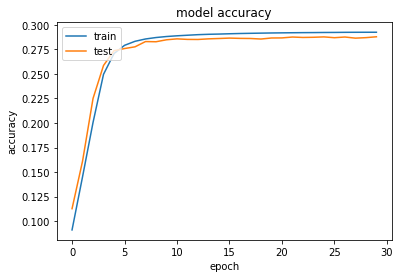

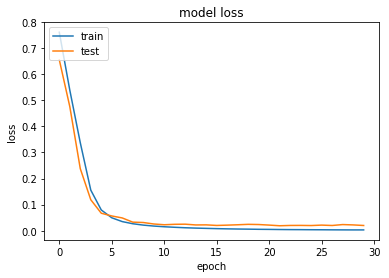

In [18]:
# Run training
import matplotlib.pyplot as plt
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model
model.save(model_name)
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_accuracy_small.png')
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_loss_small.png')

Sampling model for decoding

In [19]:
# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

decoding function

In [20]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

Testing 

In [23]:

for seq_index in range(100):
    # Take one sequence (part of the training test)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

print('-----------------------run from test.txt')



for seq_index in range(len(encoder_input_data_test)):
    # Take one sequence (test)
    # for trying out decoding.
    input_seq = encoder_input_data_test[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence (from test file):', test_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: আটালি

Decoded sentence: আটালি

-
Input sentence: কপিরাইটে

Decoded sentence: কপিরাইট

-
Input sentence: কাশিমপুরের

Decoded sentence: কাশিমপুর

-
Input sentence: ধরপাকড়ের

Decoded sentence: ধরপাকড়

-
Input sentence: ফেটিন

Decoded sentence: ফেটিন

-
Input sentence: ফ্রামের

Decoded sentence: ফ্রাম

-
Input sentence: পদক্ষেপগুলো

Decoded sentence: পদক্ষেপ

-
Input sentence: গোঁড়াদের

Decoded sentence: গোঁড়া

-
Input sentence: জেসিকার

Decoded sentence: জেসিকা

-
Input sentence: চিনিকলের

Decoded sentence: চিনিকল

-
Input sentence: দারোগাকে

Decoded sentence: দারোগা

-
Input sentence: মোশাররফও

Decoded sentence: মোশাররফ

-
Input sentence: মনোয়ারার

Decoded sentence: মনোয়ারা

-
Input sentence: বেতনকাঠামোর

Decoded sentence: বেতনকাঠামো

-
Input sentence: সরদারপাড়ার

Decoded sentence: সরদারপাড়া

-
Input sentence: সময়েই

Decoded sentence: সময়

-
Input sentence: স্কিফবোটে

Decoded sentence: স্কিফবোট

-
Input sentence: করোনেশনে

Decoded sentence: করোনেশন

-
Input sentence: শ

-
Input sentence (from test file): এই

Decoded sentence: এই

-
Input sentence (from test file): পেসার

Decoded sentence: পেসা

-
Input sentence (from test file): জরিমানার

Decoded sentence: জরিমানা

-
Input sentence (from test file): পাশাপাশি

Decoded sentence: পাশাপাশি

-
Input sentence (from test file): তাঁর

Decoded sentence: তাঁর

-
Input sentence (from test file): নামে

Decoded sentence: নামে

-
Input sentence (from test file): তিনটি

Decoded sentence: তিন

-
Input sentence (from test file): ডিমেরিট

Decoded sentence: ডিমের

-
Input sentence (from test file): পয়েন্ট

Decoded sentence: পয়েন্ট

-
Input sentence (from test file): যোগ

Decoded sentence: যোগ

-
Input sentence (from test file): করা

Decoded sentence: করা

-
Input sentence (from test file): হয়েছে
Decoded sentence: হয়েছেয়াটিন

